In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

In [193]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

df_test = df_test.drop(columns=['id'])
df_test.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,40.0,175.0,70.0,84.0,1.5,1.5,1.0,1.0,120.0,59.0,100.0,179.0,122.0,45.0,109.0,16.0,1.0,1.0,15.0,9.0,25.0,0.0
1,45.0,155.0,55.0,72.4,0.6,0.5,1.0,1.0,102.0,68.0,87.0,186.0,104.0,56.0,109.0,11.5,1.0,0.8,14.0,10.0,13.0,0.0
2,40.0,160.0,55.0,76.0,1.2,1.2,1.0,1.0,115.0,64.0,93.0,167.0,84.0,77.0,74.0,13.3,1.0,0.8,14.0,10.0,11.0,0.0
3,45.0,150.0,50.0,74.4,1.0,1.0,1.0,1.0,96.0,67.0,72.0,179.0,63.0,85.0,82.0,13.4,1.0,0.7,23.0,15.0,18.0,0.0
4,35.0,185.0,80.0,90.0,0.8,1.0,1.0,1.0,113.0,73.0,82.0,183.0,89.0,59.0,105.0,15.6,1.0,0.9,16.0,26.0,20.0,0.0


In [191]:
df_train.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55.0,170.0,80.0,92.0,1.2,0.8,1.0,1.0,129.0,74.0,82.0,175.0,58.0,49.0,114.0,15.4,1.0,0.9,20.0,23.0,13.0,0.0,0.0
1,1,30.0,170.0,80.0,94.0,1.5,1.5,1.0,1.0,128.0,84.0,95.0,188.0,128.0,51.0,111.0,16.2,1.0,0.9,30.0,39.0,92.0,0.0,1.0
2,2,45.0,170.0,75.0,84.0,1.0,1.0,1.0,1.0,124.0,80.0,98.0,192.0,138.0,52.0,112.0,14.6,2.0,0.9,20.0,20.0,50.0,0.0,1.0
3,3,55.0,150.0,55.0,85.0,0.9,0.5,1.0,1.0,123.0,79.0,95.0,193.0,65.0,61.0,119.0,13.4,1.0,0.8,25.0,20.0,18.0,0.0,0.0
4,4,45.0,160.0,55.0,72.0,0.5,0.6,1.0,1.0,117.0,76.0,103.0,197.0,81.0,61.0,120.0,13.9,1.0,0.7,20.0,26.0,10.0,0.0,0.0


# Feature engeenering

In [195]:
# Create new features

# 1. Cholesterol to LDL Ratio
df_train['cholesterol_ldl_ratio'] = df_train['Cholesterol'] / df_train['LDL']

# 2. BMI (Body Mass Index) = weight(kg) / height(m)^2
df_train['bmi'] = df_train['weight(kg)'] / (df_train['height(cm)'] / 100) ** 2

# 3. Waist-to-Height Ratio
df_train['waist_to_height_ratio'] = df_train['waist(cm)'] / df_train['height(cm)']

# 4. Blood Pressure Difference (Systolic - Relaxation)
df_train['bp_difference'] = df_train['systolic'] - df_train['relaxation']

# Check the new features
df_train[['cholesterol_ldl_ratio', 'bmi', 'waist_to_height_ratio', 'bp_difference']].head()


,cholesterol_ldl_ratio,bmi,waist_to_height_ratio,bp_difference
0,1.535088,27.681661,0.541176,55.0
1,1.693694,27.681661,0.552941,44.0
2,1.714286,25.951557,0.494118,44.0
3,1.621849,24.444444,0.566667,44.0
4,1.641667,21.484375,0.450000,41.0


In [196]:
# Create new features

# 1. Cholesterol to LDL Ratio
df_test['cholesterol_ldl_ratio'] = df_test['Cholesterol'] / df_test['LDL']

# 2. BMI (Body Mass Index) = weight(kg) / height(m)^2
df_test['bmi'] = df_test['weight(kg)'] / (df_test['height(cm)'] / 100) ** 2

# 3. Waist-to-Height Ratio
df_test['waist_to_height_ratio'] = df_test['waist(cm)'] / df_test['height(cm)']

# 4. Blood Pressure Difference (Systolic - Relaxation)
df_test['bp_difference'] = df_test['systolic'] - df_test['relaxation']

# Check the new features
df_test[['cholesterol_ldl_ratio', 'bmi', 'waist_to_height_ratio', 'bp_difference']].head()

,cholesterol_ldl_ratio,bmi,waist_to_height_ratio,bp_difference
0,1.642202,22.857143,0.480000,61.0
1,1.706422,22.892820,0.467097,34.0
2,2.256757,21.484375,0.475000,51.0
3,2.182927,22.222222,0.496000,29.0
4,1.742857,23.374726,0.486486,40.0


In [197]:
X = df_train.drop(columns=['smoking','id'])
y = df_train['smoking']

# Split data into train and test for demonstration purposes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [198]:
model = RandomForestClassifier(
        n_estimators=235,
        max_depth=9,
        min_samples_split=4,
        min_samples_leaf=1,
        max_features='sqrt',
        bootstrap=False,
        random_state=42,
        n_jobs=-1
    )

roc_auc_train = cross_val_score(model, X_train, y_train, cv=3, scoring="roc_auc", n_jobs=-1).mean()
roc_auc_test = cross_val_score(model, X_test, y_test, cv=3, scoring="roc_auc", n_jobs=-1).mean()
print(roc_auc_train)
print(roc_auc_test)


0.8814979724727419
0.8730118603989553


ROC AUC Score: 0.88


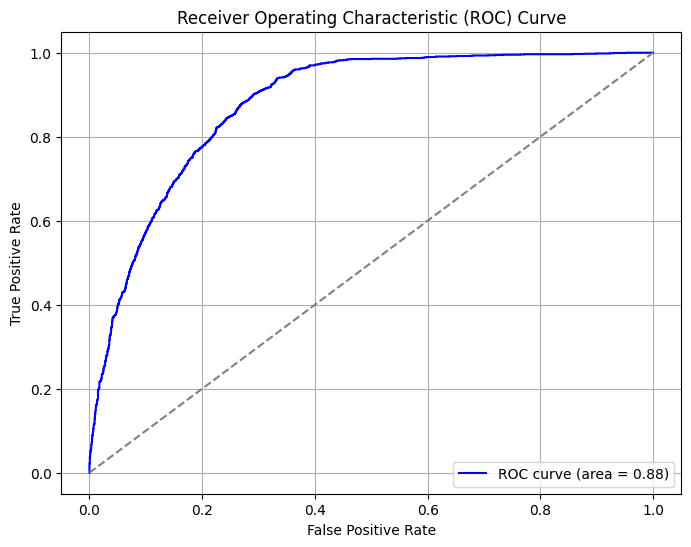

In [199]:
# Get the predicted probabilities for the positive class (class 1)
model.fit(X_train,y_train)
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print(f'ROC AUC Score: {roc_auc:.2f}')

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [200]:
df_test.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,cholesterol_ldl_ratio,bmi,waist_to_height_ratio,bp_difference
0,40.0,175.0,70.0,84.0,1.5,1.5,1.0,1.0,120.0,59.0,100.0,179.0,122.0,45.0,109.0,16.0,1.0,1.0,15.0,9.0,25.0,0.0,1.642202,22.857143,0.480000,61.0
1,45.0,155.0,55.0,72.4,0.6,0.5,1.0,1.0,102.0,68.0,87.0,186.0,104.0,56.0,109.0,11.5,1.0,0.8,14.0,10.0,13.0,0.0,1.706422,22.892820,0.467097,34.0
2,40.0,160.0,55.0,76.0,1.2,1.2,1.0,1.0,115.0,64.0,93.0,167.0,84.0,77.0,74.0,13.3,1.0,0.8,14.0,10.0,11.0,0.0,2.256757,21.484375,0.475000,51.0
3,45.0,150.0,50.0,74.4,1.0,1.0,1.0,1.0,96.0,67.0,72.0,179.0,63.0,85.0,82.0,13.4,1.0,0.7,23.0,15.0,18.0,0.0,2.182927,22.222222,0.496000,29.0
4,35.0,185.0,80.0,90.0,0.8,1.0,1.0,1.0,113.0,73.0,82.0,183.0,89.0,59.0,105.0,15.6,1.0,0.9,16.0,26.0,20.0,0.0,1.742857,23.374726,0.486486,40.0


In [201]:
# Get the predicted probabilities for the positive class (class 1)
model.fit(X_train,y_train)
y_prob = model.predict_proba(df_test)[:, 1]


In [202]:
submission.head()

,id,smoking
0,15000,0.5
1,15001,0.5
2,15002,0.5
3,15003,0.5
4,15004,0.5


In [203]:
submission['smoking'] = y_prob

submission.to_csv('my_submission.csv',index=False)

submission

,id,smoking
0,15000,0.718332
1,15001,0.016084
2,15002,0.019704
3,15003,0.058246
4,15004,0.430312
...,...,...
9995,24995,0.362168
9996,24996,0.792684
9997,24997,0.355990
9998,24998,0.013270
